### Connect to Google Drive for Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset of Skin Images

In [4]:
!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d nodoubttome/skin-cancer9-classesisic

Dataset URL: https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic
License(s): other
 99% 779M/786M [00:07<00:00, 91.5MB/s]
100% 786M/786M [00:07<00:00, 106MB/s] 


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/skin-cancer9-classesisic.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### Import Libraries

In [7]:
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from  tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam, SGD

### Load our Skin Images (Define Paths)

In [8]:
dirpath = os.getcwd()
PATH = os.path.join(dirpath, 'Skin cancer ISIC The International Skin Imaging Collaboration')
PATH_ak = os.path.join(PATH, 'Train/actinic keratosis')
PATH_bcc = os.path.join(PATH, 'Train/basal cell carcinoma')
PATH_derm = os.path.join(PATH, 'Train/dermatofibroma')
PATH_mel = os.path.join(PATH, 'Train/melanoma')
PATH_nev = os.path.join(PATH, 'Train/nevus')
PATH_pbk = os.path.join(PATH, 'Train/pigmented benign keratosis')
PATH_sk = os.path.join(PATH, 'Train/seborrheic keratosis')
PATH_scc = os.path.join(PATH, 'Train/squamous cell carcinoma')
PATH_vl = os.path.join(PATH, 'Train/vascular lesion')
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

#### Get Paths of All Images to Load them


In [9]:
files_ak = os.listdir(PATH_ak)
files_bcc = os.listdir(PATH_bcc)
files_derm = os.listdir(PATH_derm)
files_mel = os.listdir(PATH_mel)
files_nev = os.listdir(PATH_nev)
files_pbk = os.listdir(PATH_pbk)
files_sk = os.listdir(PATH_sk)
files_scc = os.listdir(PATH_scc)
files_vl = os.listdir(PATH_vl)
print(len(files_ak), len(files_bcc), len(files_derm), len(files_mel), len(files_nev), len(files_pbk), len(files_sk), len(files_scc), len(files_vl))

paths_ak = [os.path.join(PATH_ak, file) for file in files_ak]
paths_bcc = [os.path.join(PATH_bcc, file) for file in files_bcc]
paths_derm = [os.path.join(PATH_derm, file) for file in files_derm]
paths_mel = [os.path.join(PATH_mel, file) for file in files_mel]
paths_nev = [os.path.join(PATH_nev, file) for file in files_nev]
paths_pbk = [os.path.join(PATH_pbk, file) for file in files_pbk]
paths_sk = [os.path.join(PATH_sk, file) for file in files_sk]
paths_scc = [os.path.join(PATH_scc, file) for file in files_scc]
paths_val = [os.path.join(PATH_vl, file) for file in files_vl]

paths_all = np.concatenate([paths_ak, paths_bcc, paths_derm, paths_mel, paths_nev, paths_pbk, paths_sk, paths_scc, paths_val])

114 376 95 438 357 462 77 181 139


#### Define the Y (Target) Data

In [10]:
y_ak = [0 for i in range(len(files_ak))]
y_bcc = [1 for i in range(len(files_bcc))]
y_derm = [2 for i in range(len(files_derm))]
y_mel = [3 for i in range(len(files_mel))]
y_nev = [4 for i in range(len(files_nev))]
y_pbk = [5 for i in range(len(files_pbk))]
y_sk = [6 for i in range(len(files_sk))]
y_scc = [7 for i in range(len(files_scc))]
y_vl = [8 for i in range(len(files_vl))]
y_all = np.concatenate([y_ak, y_bcc, y_derm, y_mel, y_nev, y_pbk, y_sk, y_scc, y_vl])
y_all[0]

0

#### Turn Class Labels into a Categorical Label for Keras

In [11]:
num_categories = 9
y_all = keras.utils.to_categorical(y_all, num_categories)
y_all[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0.])

#### Display Random Defect Image From Each Category

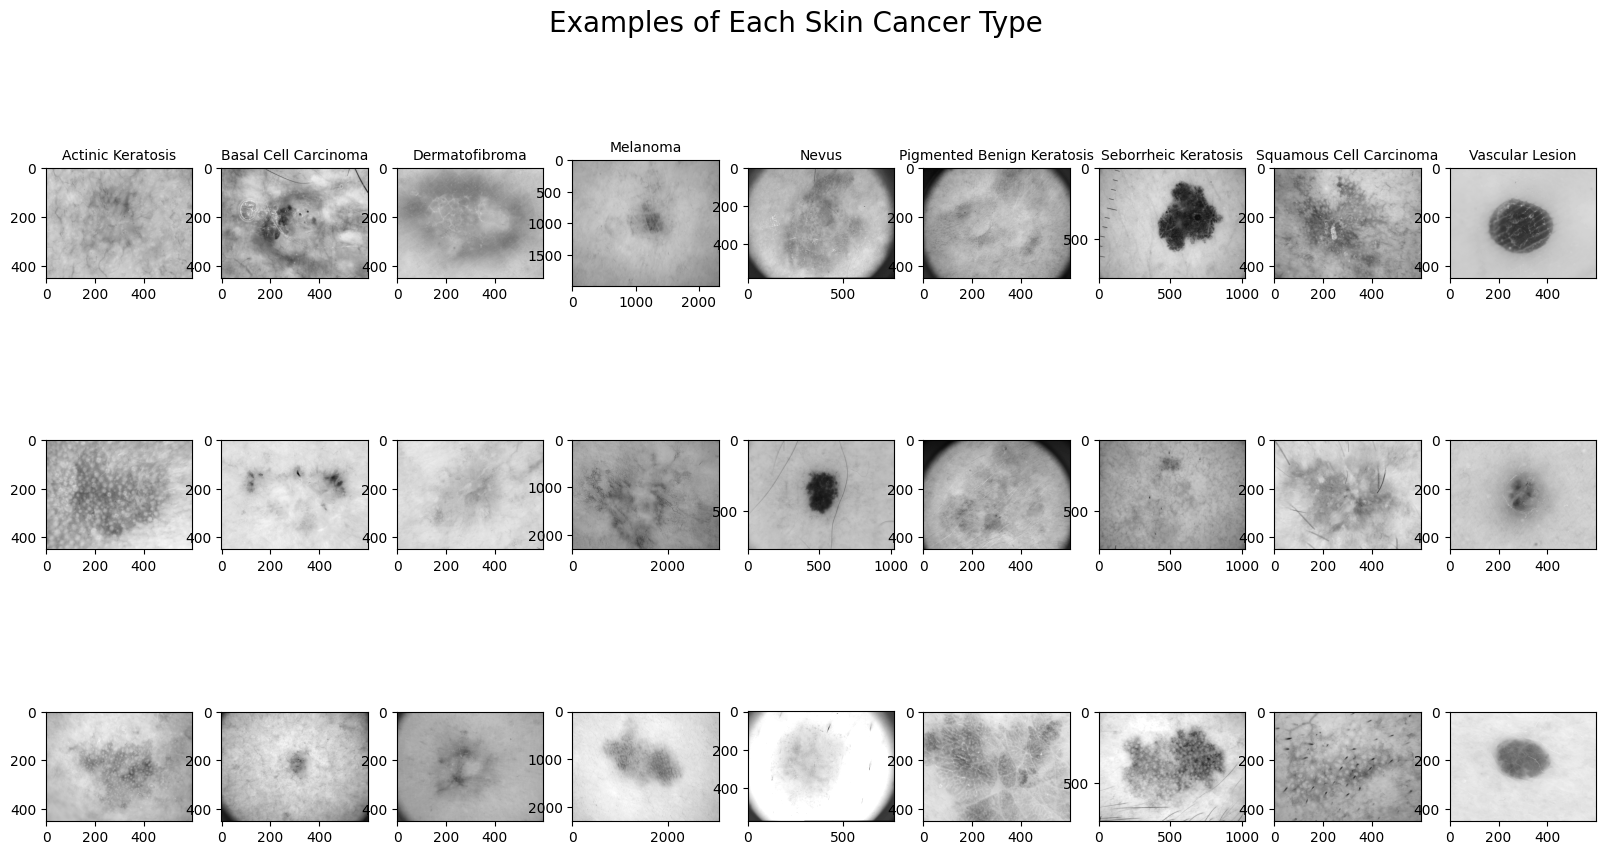

In [12]:
im_ak = [Image.open(os.path.join(PATH_ak, files_ak[np.random.randint(0, len(files_ak))])).convert('L'),
        Image.open(os.path.join(PATH_ak, files_ak[np.random.randint(0, len(files_ak))])).convert('L'),
        Image.open(os.path.join(PATH_ak, files_ak[np.random.randint(0, len(files_ak))])).convert('L')]
im_bcc = [Image.open(os.path.join(PATH_bcc, files_bcc[np.random.randint(0, len(files_bcc))])).convert('L'),
          Image.open(os.path.join(PATH_bcc, files_bcc[np.random.randint(0, len(files_bcc))])).convert('L'),
          Image.open(os.path.join(PATH_bcc, files_bcc[np.random.randint(0, len(files_bcc))])).convert('L')]
im_derm = [Image.open(os.path.join(PATH_derm, files_derm[np.random.randint(0, len(files_derm))])).convert('L'),
          Image.open(os.path.join(PATH_derm, files_derm[np.random.randint(0, len(files_derm))])).convert('L'),
           Image.open(os.path.join(PATH_derm, files_derm[np.random.randint(0, len(files_derm))])).convert('L')]
im_mel = [Image.open(os.path.join(PATH_mel, files_mel[np.random.randint(0, len(files_mel))])).convert('L'),
          Image.open(os.path.join(PATH_mel, files_mel[np.random.randint(0, len(files_mel))])).convert('L'),
          Image.open(os.path.join(PATH_mel, files_mel[np.random.randint(0, len(files_mel))])).convert('L')]
im_nev = [Image.open(os.path.join(PATH_nev, files_nev[np.random.randint(0, len(files_nev))])).convert('L'),
          Image.open(os.path.join(PATH_nev, files_nev[np.random.randint(0, len(files_nev))])).convert('L'),
          Image.open(os.path.join(PATH_nev, files_nev[np.random.randint(0, len(files_nev))])).convert('L')]
im_pbk = [Image.open(os.path.join(PATH_pbk, files_pbk[np.random.randint(0, len(files_pbk))])).convert('L'),
          Image.open(os.path.join(PATH_pbk, files_pbk[np.random.randint(0, len(files_pbk))])).convert('L'),
          Image.open(os.path.join(PATH_pbk, files_pbk[np.random.randint(0, len(files_pbk))])).convert('L')]
im_sk = [Image.open(os.path.join(PATH_sk, files_sk[np.random.randint(0, len(files_sk))])).convert('L'),
         Image.open(os.path.join(PATH_sk, files_sk[np.random.randint(0, len(files_sk))])).convert('L'),
         Image.open(os.path.join(PATH_sk, files_sk[np.random.randint(0, len(files_sk))])).convert('L')]
im_scc = [Image.open(os.path.join(PATH_scc, files_scc[np.random.randint(0, len(files_scc))])).convert('L'),
          Image.open(os.path.join(PATH_scc, files_scc[np.random.randint(0, len(files_scc))])).convert('L'),
          Image.open(os.path.join(PATH_scc, files_scc[np.random.randint(0, len(files_scc))])).convert('L')]
im_vl = [Image.open(os.path.join(PATH_vl, files_vl[np.random.randint(0, len(files_vl))])).convert('L'),
         Image.open(os.path.join(PATH_vl, files_vl[np.random.randint(0, len(files_vl))])).convert('L'),
         Image.open(os.path.join(PATH_vl, files_vl[np.random.randint(0, len(files_vl))])).convert('L')]

import cv2

fig, axs = plt.subplots(len(im_ak),9)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.suptitle("Examples of Each Skin Cancer Type", fontsize=20)
for i, im in enumerate(im_ak):
  axs[i][0].imshow(im, cmap ="gray", vmin = 0, vmax = 225)
  axs[0][0].set_title('Actinic Keratosis', fontsize=10)
for i, im in enumerate(im_bcc):
  axs[i][1].imshow(im, cmap ="gray", vmin = 0, vmax=225)
  axs[0][1].set_title('Basal Cell Carcinoma', fontsize=10)
for i, im in enumerate(im_derm):
  axs[i][2].imshow(im, cmap ="gray", vmin = 0, vmax=225)
  axs[0][2].set_title('Dermatofibroma', fontsize=10)
for i, im in enumerate(im_mel):
  axs[i][3].imshow(im, cmap ="gray", vmin = 0, vmax=225)
  axs[0][3].set_title('Melanoma', fontsize=10)
for i, im in enumerate(im_nev):
  axs[i][4].imshow(im, cmap ="gray", vmin = 0, vmax=225)
  axs[0][4].set_title('Nevus', fontsize=10)
for i, im in enumerate(im_pbk):
  axs[i][5].imshow(im, cmap ="gray", vmin = 0, vmax=225)
  axs[0][5].set_title('Pigmented Benign Keratosis', fontsize=10)
for i, im in enumerate(im_sk):
  axs[i][6].imshow(im, cmap ="gray", vmin = 0, vmax=225)
  axs[0][6].set_title('Seborrheic Keratosis', fontsize=10)
for i, im in enumerate(im_scc):
  axs[i][7].imshow(im, cmap ="gray", vmin = 0, vmax=225)
  axs[0][7].set_title('Squamous Cell Carcinoma', fontsize=10)
for i, im in enumerate(im_vl):
  axs[i][8].imshow(im, cmap ="gray", vmin = 0, vmax=225)
  axs[0][8].set_title('Vascular Lesion', fontsize=10)


# Cancer Detection With Convolutional Connected Network (CNN)
#### Crop images so that they are the same size

In [21]:
target_size =  (200, 200)

def crop_center_opencv(image, size):
  height, width = image.shape[:2]
  top = (height - size[1]) // 2
  bottom = top + size[1]
  left = (width - size[0]) // 2
  right = left + size[0]
  return image[top:bottom, left:right]

category_paths = [PATH_ak, PATH_bcc, PATH_derm,  PATH_mel, PATH_nev, PATH_pbk, PATH_sk, PATH_scc, PATH_vl]

cropped_dir = os.path.join(dirpath, 'Cropped_Images')
os.makedirs(cropped_dir, exist_ok=True)

for i, category_path in enumerate(category_paths):
  category_name = class_names[i]
  save_dir = os.path.join(cropped_dir, category_name)
  os.makedirs(save_dir, exist_ok=True)

  files = os.listdir(category_path)

  for file in files:
    image_path = os.path.join(category_path, file)
    image = cv2.imread(image_path)

    height, width = image.shape[:2]
    if height < width:
      new_height = target_size[1]
      new_width = int(width * (new_height / height))
    else:
      new_width = target_size[0]
      new_height = int(height * (new_width / width))

    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    cropped_image = crop_center_opencv(resized_image, target_size)

    save_path = os.path.join(save_dir, file)
    cv2.imwrite(save_path, cropped_image)

print("All images have been cropped and saved")


All images have been cropped and saved


# Detect Skin Cancer with a Convolutional Neural Network (CNN)
#### Create train and validation data for our CNN

In [22]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
          img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          img = cv2.resize(img, target_size)
          img = img / 255.0
          images.append(img)
    return images

cropped_dir = os.path.join(dirpath, 'Cropped_Images')

X = []
y = []

for i, category_name in enumerate(class_names):
  category_path = os.path.join(cropped_dir, category_name)
  images = load_images_from_folder(category_path)
  X.extend(images)
  y.extend([i] * len(images))

X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0], target_size[0], target_size[1], 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


X_train shape: (2015, 200, 200, 1)
X_val shape: (224, 200, 200, 1)
y_train shape: (2015,)
y_val shape: (224,)


#### Define the architecture of our CNN

In [23]:
from tensorflow.keras import backend as K

K.clear_session()

model_cnn = Sequential()
model_cnn.add(tensorflow.keras.Input(shape=(target_size[0], target_size[1], 1)))

model_cnn.add(Conv2D(32, (3, 3), strides = 1, padding ='same',  activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPool2D(pool_size=(2, 2), strides = 2, padding = 'same'))

model_cnn.add(Conv2D(64, (3, 3), strides = 1, padding ='same',  activation='relu'))
model_cnn.add(Dropout(0.2)) # Dropout layer to prevent overfitting
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPool2D(pool_size=(2, 2), strides = 2, padding = 'same'))

#model_cnn.add(Conv2D(16, (3, 3), strides = 1, padding ='same',  activation='relu'))
#model_cnn.add(BatchNormalization())
#model_cnn.add(MaxPool2D(pool_size=(2, 2), strides = 2, padding = 'same'))

model_cnn.add(Flatten())

#### Add fully connected layers to perform classification

In [24]:
from tensorflow.keras import backend as K

K.clear_session()

# Fully Connected Layer 1
model_cnn.add(Dense(units = 16, activation='relu'))

# Output layer
model_cnn.add(Dense(units = 9, activation='softmax'))

#### Compile and print model summary

In [25]:
from tensorflow.keras import backend as K

K.clear_session()

model_cnn.compile(optimizer = SGD(learning_rate = 0.01, momentum=0.9), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 200, 200, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200, 200, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 100, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 160000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │       2,560,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,579,369 (9.84 MB)

 Trainable params: 2,579,177 (9.84 MB)

 Non-trainable params: 192 (768.00 B)

#### Define handy callback function

In [26]:
model_folder = 'model_cnn'
checkpoint_file = os.path.join(dirpath, model_folder, 'checkpoint.model.keras')
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')
mcp_save = ModelCheckpoint(checkpoint_file, save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='max')


In [ ]:
from tensorflow.keras import backend as K

K.clear_session()

y_train = to_categorical(y_train, num_classes=9)
y_val = to_categorical(y_val, num_classes=9)

history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs = 100,
    verbose = 1,
    batch_size = 32,
    validation_data = (X_val, y_val),
    callbacks = [earlyStopping, mcp_save, reduce_lr_loss]
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.1543 - loss: 16.2377 - val_accuracy: 0.2143 - val_loss: 2.9811 - learning_rate: 0.0100
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 325s 4s/step - accuracy: 0.1981 - loss: 2.0701 - val_accuracy: 0.2054 - val_loss: 2.0302 - learning_rate: 0.0100
Epoch 3/100
 7/63 ━━━━━━━━━━━━━━━━━━━━ 3:51 4s/step - accuracy: 0.1727 - loss: 2.0659

#### Plot training and validation accuracy to assess model training

In [ ]:
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(os.path.join(model_folder, model_folder, 'model_cnn_training.png'), dpi = 300, bbox_inches ='tight')
plt.show()